<a href="https://colab.research.google.com/github/kjousselin/M2_info_MP_pb1/blob/master/Data_Viz_Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Datavizualisation : Méthode K-PCA**
#### <i>Par Meriem Bencheikh et Kévin Jousselin </i>
<u>Consignes :</u>
Expliquer le principe d'une méthode de réduction de dimension (intuitivement, mathématiquement, et informatiquement (quels paramètres à régler)). Appliquer cette méthodes aux données de croissance de plantes. Vous présenterez vos travaux à l'oral sous forme d'un support graphique de votre choix (jupyter note book, powerpoint, ...)

<u>Quelques ressources :</u>

https://iq.opengenus.org/kernal-principal-component-analysis/#:~:text=Kernel%20Principal%20Component%20Analysis%20(KPCA)%20is%20a%20non%2Dlinear,reduction%20technique%20%2D%20using%20kernel%20methods.

https://openclassrooms.com/fr/courses/4379436-explorez-vos-donnees-avec-des-algorithmes-non-supervises/4379521-utilisez-une-acp-avec-un-noyau

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# PARTIE I - RECUPERER ET TRAITER LES DONNEES

In [ ]:
# Fichiers d'entrée et de sortie :
fichier = "matrix_growth_curves_02_04_05_07.xlsx"
dossier_import = ''
dossier_export = "output"

# Récupérer les données et els insérer dans un dataframe
data = pd.read_excel(dossier_import+fichier)

# On enlève la numérotation (index) de l'observation
data = data.drop(['num_plt','Obs'], axis=1)


### Traitement des données manquantes

In [ ]:
def traiter_donnees_manquantes(colour = 'all'):
    """
    Traitement des données manquantes :
    1) Suppression des colonnes contenant trop de données manquantes.
    2) Suppression des lignes contenant encore trop de données manquantes
    3) Compléter les données manquantes restantes par moyennisation selon leur variété (colour = 'all' / 'Red' / 'Green' )

    La fonction renvoie le df traité de la variété demandée.
    """
    
    # Nb de données manquantes par colonne
    col_data_NA = data.isna().sum()   
    col_data_NA.sort_values(ascending=False)

    # Colonnes contenant moins de 100 données manquantes 
    sum(col_data_NA>100)
    col_data_NA_liste = data.columns[col_data_NA<100].tolist()

    # On ne garde que les colonnes qui ont moins de 100 données manquantes (18 colonnes supprimées, reste 144 )
    df = data[col_data_NA_liste]

    # NB de données manquantes par ligne
    df.isna().sum(axis=1).sort_values(ascending=False).head(20)
    sum(df.isna().sum(axis=1).sort_values(ascending=False)>15)

    # On supprime les données qui ont plus de 15 données manquantes (18 lignes, reste 366)
    df = df.loc[df.isna().sum(axis=1)<15]

    sum(df.isna().sum())  
    df.shape[0]*df.shape[1]     # reste 879 données manquantes sur un total de 51 972 cellules

    if colour != 'all':
      # On ne séléctionne que les données de la couleur demandée
      df = df[df.color == colour]
  
    # Puis on complète les données manquantes selon le DF demandé (all, green, red) par moyennisation
    df.mean(axis=0, numeric_only=True) # moyenne par colonne  
    df.isna().sum().sort_values(ascending=False)

    for colonne in df.columns:
        # tester si la colonne est numérique
        if isinstance(df[colonne].iloc[0], (int, float)):
            df.loc[df[colonne].isna(),colonne] = df[colonne].mean()

    # On vérifie qu'il ne reste aucune donnée manquante :
    print(f'Toutes les données manquantes ont été traitées : {sum(df.isna().sum()) == 0}')
    return(df)


In [ ]:
# Application de la fonction de traitement des données aux df
df_red = traiter_donnees_manquantes(colour = 'Red')
df_green = traiter_donnees_manquantes(colour = 'Green')
df_total = traiter_donnees_manquantes(colour = 'all')

Toutes les données manquantes ont été traitées : True
Toutes les données manquantes ont été traitées : True
Toutes les données manquantes ont été traitées : True


In [ ]:
# Apercu des données
print(df_red.columns)
df_red.head(5)

Index(['DP', 'BBL', 'y0_RGB', 'ymax_RGB', 'k_RGB', 'lag_RGB', 'Camera1',
       'Gr_per_day', 'Corrected_mean_Llength', 'Corrected_mean_Lwidth',
       ...
       'Depth_HDR_day_11', 'Depth_HDR_day_12', 'Depth_HDR_day_13',
       'Depth_HDR_day_14', 'Depth_HDR_day_15', 'Depth_HDR_day_16',
       'Depth_HDR_day_17', 'Depth_HDR_day_18', 'Depth_HDR_day_19',
       'Depth_HDR_day_20'],
      dtype='object', length=142)


,DP,BBL,y0_RGB,ymax_RGB,k_RGB,lag_RGB,Camera1,Gr_per_day,Corrected_mean_Llength,Corrected_mean_Lwidth,...,Depth_HDR_day_11,Depth_HDR_day_12,Depth_HDR_day_13,Depth_HDR_day_14,Depth_HDR_day_15,Depth_HDR_day_16,Depth_HDR_day_17,Depth_HDR_day_18,Depth_HDR_day_19,Depth_HDR_day_20
3,2,13,60.382549,246.845384,76.500594,12.188932,Intel5,4.391099,12.000000,6.233333,...,3368.652475,2479.168570,1293.407164,3410.780545,2344.517367,1683.992963,665.063663,302.576654,237.198333,451.384676
4,2,11,44.189020,212.875440,31.542620,13.068265,Intel5,4.024621,11.433333,3.466667,...,3337.262055,2432.778494,598.076722,76.167940,245.839194,353.730785,523.471416,826.295519,1054.595003,1131.501438
5,2,14,52.201500,131.409610,65.338627,14.896403,Intel5,3.903883,12.666667,7.000000,...,412.455836,138.266373,92.787699,1797.510923,1086.649198,549.122485,333.299077,162.410783,1246.788319,603.622613
9,2,11,57.691590,1158.542580,89.407497,21.001221,Intel5,4.085227,10.800000,4.833333,...,689.760580,220.312525,756.868278,347.793867,458.177237,491.923677,586.272444,1195.501564,1451.915211,1697.420922
10,2,13,54.527930,140.890040,62.353746,14.829035,Intel5,3.825455,12.133333,6.100000,...,92.088408,149.744014,112.798510,199.641121,262.386151,482.237319,301.060257,925.462006,1584.352922,1130.006087


### Visualisation des données et recherche des données abhérantes.

Dans cette sections, on visualise les données afin de rechercher des données abhérantes.

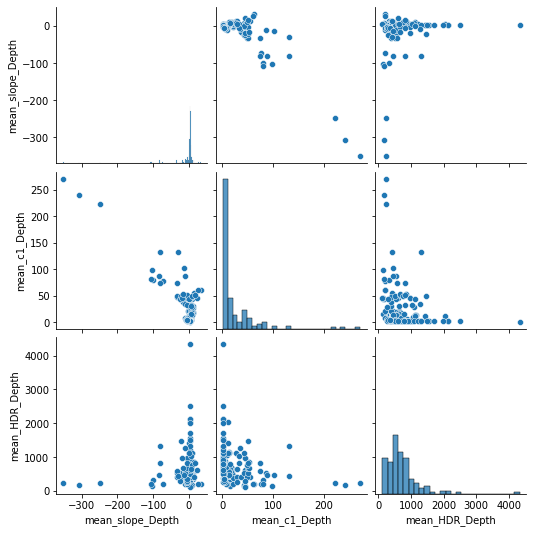

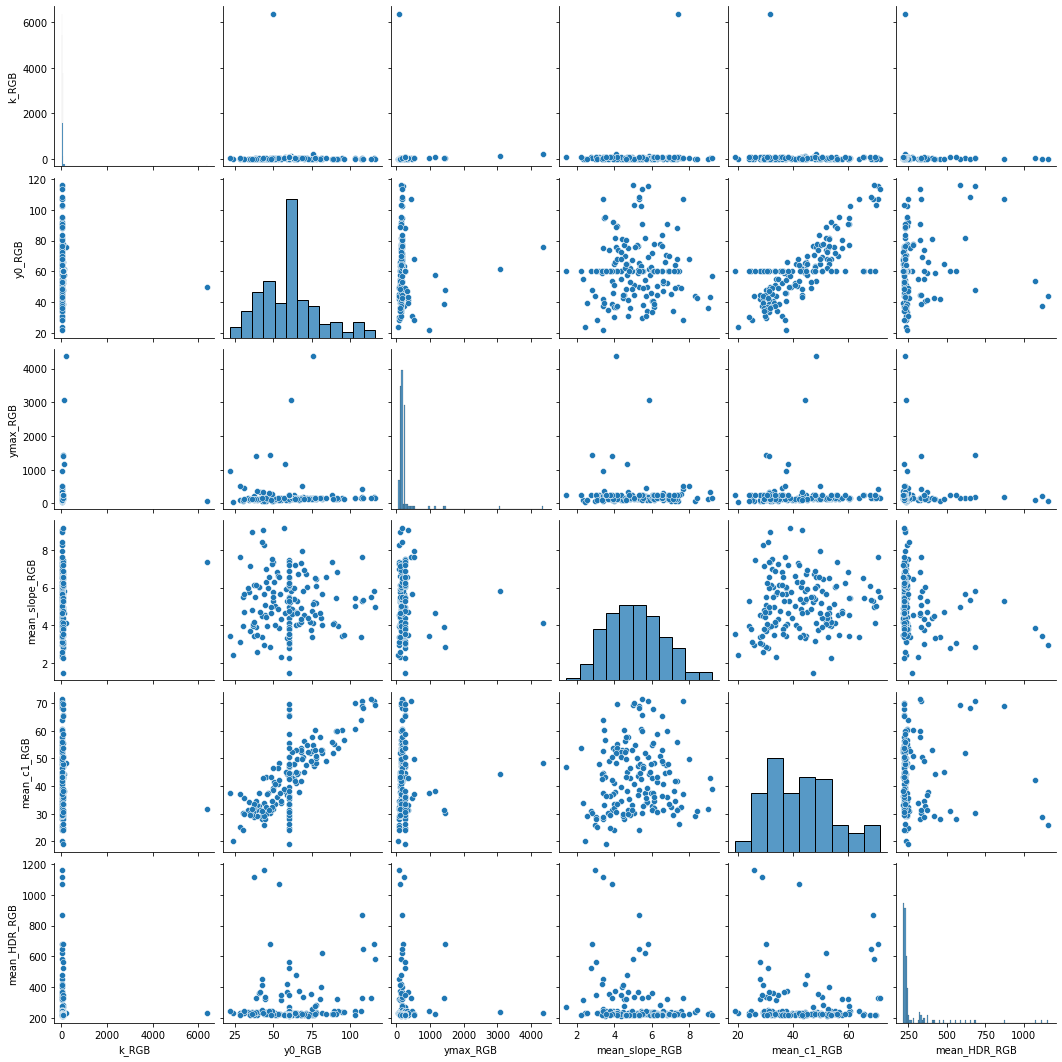

     DP  BBL    y0_RGB  ymax_RGB        k_RGB    lag_RGB Camera1  Gr_per_day  \
217   5   14  49.52894  76.34877  6376.217381  15.259635  Intel6    4.210101   

     Corrected_mean_Llength  Corrected_mean_Lwidth  ...  Depth_HDR_day_11  \
217                    12.9                    8.0  ...        158.945777   

    Depth_HDR_day_12  Depth_HDR_day_13  Depth_HDR_day_14  Depth_HDR_day_15  \
217       139.980089        150.205423        257.947188         44.506847   

     Depth_HDR_day_16  Depth_HDR_day_17  Depth_HDR_day_18  Depth_HDR_day_19  \
217       1138.087845        894.173908        641.603002        899.901312   

     Depth_HDR_day_20  
217       1374.344385  

[1 rows x 142 columns]
Int64Index([217], dtype='int64')


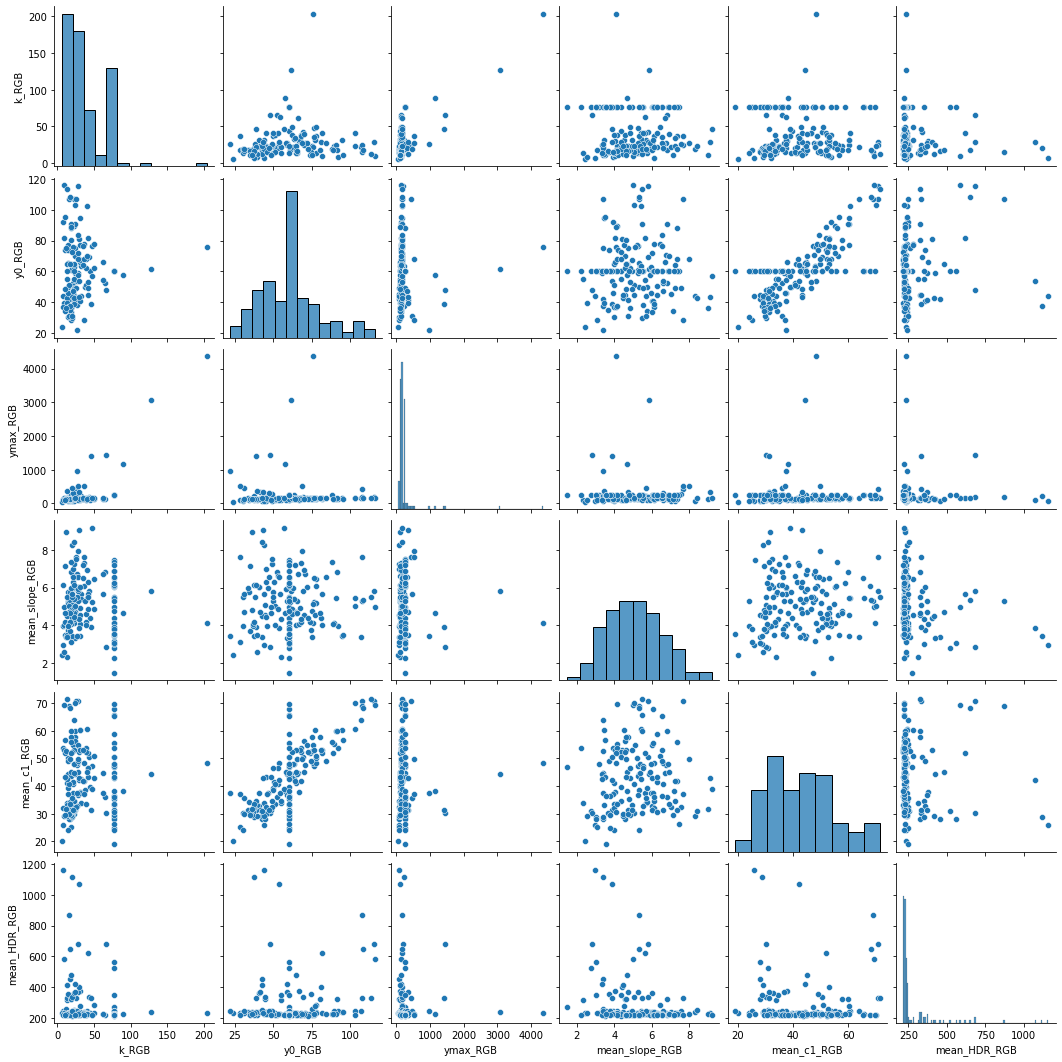

In [ ]:
# Boite à moustache représentant les données :
fig = px.box(df_total, x="Camera1", y= "k_RGB")
fig.show()

"""
Variables liées à Depth :   y0_Depth	ymax_Depth	k_Depth	lag_Depth mean_slope_Depth	mean_c1_Depth	mean_HDR_Depth
Variables liées à RGB :     k_RGB	 y0_RGB	ymax_RGB mean_slope_RGB	mean_c1_RGB	mean_HDR_RGB
'mean_HDR_RGB' in list(df_green.columns)
"""

# Comparaison des variables 'RGB' deux à deux :
sns.pairplot(df_red[['mean_slope_Depth', 'mean_c1_Depth', 'mean_HDR_Depth']])
sns.pairplot(df_red[['k_RGB', 'y0_RGB', 'ymax_RGB', 'mean_slope_RGB', 'mean_c1_RGB', 'mean_HDR_RGB']])
plt.show()

# La ligne 217 est abhérante
print(df_red[df_red['k_RGB']>1000])
"""
df_red['k_RGB'][217] > 6000 
pour un quantile 0.9
df_red['k_RGB'].quantile(0.9) < 77
"""
print(df_red.query('k_RGB>1000').index)
# on l'enlève
df_red = df_red.drop(df_red.query('k_RGB>1000').index)
df_total = df_total.drop(df_total.query('k_RGB>1000').index)

sns.pairplot(df_red[['k_RGB', 'y0_RGB', 'ymax_RGB', 'mean_slope_RGB', 'mean_c1_RGB', 'mean_HDR_RGB']])

fig = px.box(df_total, x="Camera1", y= "k_RGB")
fig.show()


L'étude a revélé une donnée abhérante parmis les salades 'rouges' (df_red) et nous l'avons supprimé,
L'étude de df_green n'a pas révélé de valeurs abhérantes.




---

# Partie II - Réduction de dimension par ACP

Nous avons décidé de faire notre étude sur l'ensemble de données traitées (df_total). Mais nous pouvons aussi choisir de mener une étude plus détaillée sur les salades rouges uniquement (df_red) ou vertes (df_green).


In [ ]:
df = df_total

import sklearn

from sklearn.decomposition import PCA

mypca = PCA(n_components=3) # On paramètre ici pour ne garder que 3 composantes principales

# Modèle d'ACP
df2 = df.drop(['Camera1','color','BBL'], axis=1)    # On ne garde que les variables quantitatives

from sklearn.preprocessing import scale
df2 = scale(df2)
mypca.fit(df2)

# Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
print("Valeurs de variance :\t", mypca.singular_values_)          # Valeurs de variance
print("En pourcentage : \t", mypca.explained_variance_ratio_)                          # en pourcentages

# Axes principaux dans l'espace des caractéristiques, représentant les directions de la variance maximale dans les données. Les composantes sont triées par variance expliquée.
print("5 premières composantes principales : \n",mypca.components_[:,:5])

# Résultats de l'ACP

data_sortie = mypca.fit_transform(df2)

pca_df = pd.DataFrame({
    "Dim1" : data_sortie[:,0], 
    "Dim2" : data_sortie[:,1],
    "Dim3" : data_sortie[:,2],
    "BBL" : df['BBL'],
    "color" : df['color'],
    "ymax_RGB" : df['ymax_RGB'],
    "mean_slope_Depth": df['mean_slope_Depth'],
    "mean_slope_RGB": df['mean_slope_RGB']
})

Valeurs de variance :	 [95.87999005 76.13818313 56.99762923]
En pourcentage : 	 [0.18119587 0.11426082 0.06403331]
5 premières composantes principales : 
 [[ 0.09872405  0.000661    0.00835137  0.01764241 -0.02429986]
 [-0.11637781  0.21805256  0.01420999  0.0225579   0.0198861 ]
 [ 0.11140187  0.05343134 -0.00800997  0.02124018 -0.05439674]]


### Projection sur les deux premiers axes principaux

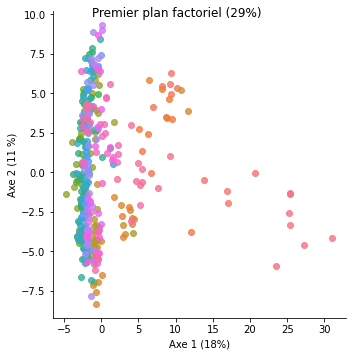

In [ ]:
# Affichage en fonction de la variété 'BBL'
#sns.lmplot(data = pca_df, x='Dim1', y='Dim2', hue ='BBL', fit_reg= False)

# Affichage en fonction de la couleur de la 'laitue'
#sns.lmplot(data = pca_df, x='Dim1', y='Dim2', hue ='color', fit_reg= False)

# Affichage en fonction de la couleur en fonction de la variable 'mean_slope_Depth'
sns.lmplot(data = pca_df, x='Dim1', y='Dim2', hue ='mean_slope_Depth', fit_reg= False,legend=False)

plt.xlabel("Axe 1 (18%)")  # modification du nom de l'axe X
plt.ylabel("Axe 2 (11 %)") # idem pour axe Y
plt.suptitle("Premier plan factoriel (29%)") # titre général
plt.show()


### Représentation en 3D (projection de l'ACP sur les 3 premiers axes)

In [ ]:
#############Representation 3D de l'ACP ################
# Affichage en fonction de  'mean_slope_depth'
fig = px.scatter_3d(df, x=pca_df["Dim1"], y=pca_df["Dim2"], z=pca_df["Dim3"],
              color='mean_slope_Depth', symbol='color') #mean_slope_Depth separe mieux 
                                                         #les symboles: representent la couleur de la salade
                                                          # les couleurs : mean_slope_depth
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene = dict(
                    xaxis_title='Dim 1',
                    yaxis_title='Dim 2',
                    zaxis_title='Dim 3'))                                                          
fig.show()
plt.show()



# Partie III - Réduction de dimension par KACP



In [ ]:
from seaborn.relational import scatterplot
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split

#Projection 2D
def Test_KPCA(gamma, kernel = 'rbf'):   
  """
  kernel{‘linear’, ‘poly’, ‘rbf’, 'sigmoid', 'cosine', ‘precomputed’}, default=’linear’
  gamma : Kernel coefficient for rbf, poly and sigmoid kernels.
  """
  kpca = KernelPCA( kernel=kernel,fit_inverse_transform=True, gamma=gamma)
  X_kpca = kpca.fit_transform(df2)
  kpca_df = pd.DataFrame({
      "Dim1" : X_kpca[:,0], 
      "Dim2" : X_kpca[:,1],
      "BBL" : df['BBL'],
      "color" : df['color'],
      "ymax_RGB" : df['ymax_RGB'],
      "mean_slope_Depth": df['mean_slope_Depth'],
      "mean_slope_RGB": df['mean_slope_RGB']
  })

  """
  var_ratio = kpca.explained_variance_ratio_
  plt.xlabel(f"Dimension 1 ({round(var_ratio[0]*100)}%)") # modification du nom de l'axe X
  plt.ylabel(f"Dimension 2 ({round(var_ratio[1]*100)}%)") # idem pour axe Y
  plt.suptitle("Premier plan factoriel") # titre général
  """

  sns.lmplot(data = kpca_df, x='Dim1', y='Dim2', hue ='mean_slope_Depth', fit_reg= False,legend=False)
  sns.color_palette("viridis", as_cmap=True)

  plt.title(f'gamma = {gamma}')

  plt.show()

In [ ]:
#Projection 3D
def Test_KPCA3D(gamma, kernel = 'rbf'):   
  """
  kernel{‘linear’, ‘poly’, ‘rbf’, 'sigmoid', 'cosine', ‘precomputed’}, default=’linear’
  gamma : Kernel coefficient for rbf, poly and sigmoid kernels.
  """
  kpca = KernelPCA( n_components = 3,kernel=kernel,fit_inverse_transform=True, gamma=gamma)
  X_kpca = kpca.fit_transform(df2)
  kpca_df = pd.DataFrame({
      "Dim1" : X_kpca[:,0], 
      "Dim2" : X_kpca[:,1],
      "Dim3" : X_kpca[:,2],
      "BBL" : df['BBL'],
      "color" : df['color'],
      "ymax_RGB" : df['ymax_RGB'],
      "mean_slope_Depth": df['mean_slope_Depth'],
      "mean_slope_RGB": df['mean_slope_RGB']
  })

  """
  var_ratio = kpca.explained_variance_ratio_
  plt.xlabel(f"Dimension 1 ({round(var_ratio[0]*100)}%)") # modification du nom de l'axe X
  plt.ylabel(f"Dimension 2 ({round(var_ratio[1]*100)}%)") # idem pour axe Y
  plt.suptitle("Premier plan factoriel") # titre général
  """

  fig = px.scatter_3d(df, x=kpca_df["Dim1"], y=kpca_df["Dim2"], z=kpca_df["Dim3"],
              color='mean_slope_Depth',symbol='color', title=f"Noyau : {kernel}") #mean_slope_Depth separe mieux 
                                                        #les symboles: representent la couleur de la salade
                                                        # les couleurs : mean_slope_depth
  fig.update_layout( title=f"Noyau : {kernel}",
      margin=dict(l=0, r=0, b=0, t=0),scene = dict(
                    xaxis_title='Dim 1',
                    yaxis_title='Dim 2',
                    zaxis_title='Dim 3'))
  


                                      
  fig.show()

### Dans la suite : quelques essais de représentations graphiques en 2D ou 3D avec différents noyaux et différentes valeurs de gamma :

In [ ]:
Test_KPCA3D(gamma=0.5, kernel = 'cosine') #cosine 3d

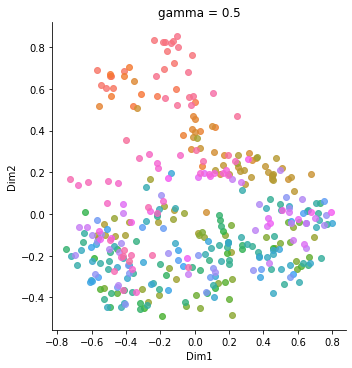

In [ ]:
Test_KPCA(gamma=0.5, kernel = 'cosine') #kernel : cosine 2d

In [ ]:
#Noyau sigmoid 
Test_KPCA3D(None,'sigmoid') #3d

In [ ]:
#Noyau lineaire  == ACP 
Test_KPCA3D(None,'linear') #3d


In [ ]:
for gamma in range(1,21,5):
  Test_KPCA3D(gamma,'rbf')

""" 
poly indépendant de gamma
sigmoid ne marche pas
"""

' \npoly indépendant de gamma\nsigmoid ne marche pas\n'

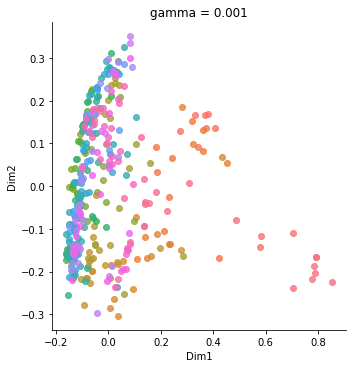

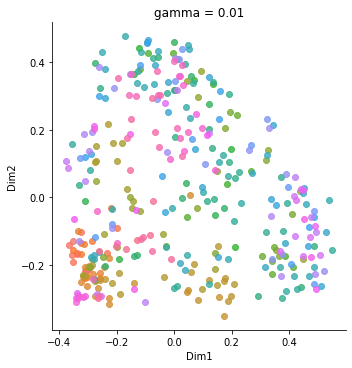

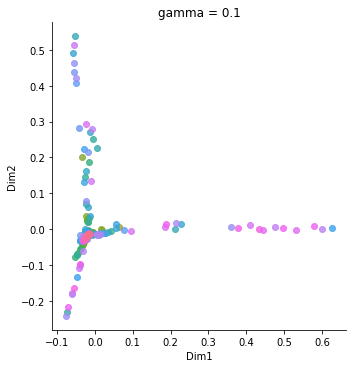

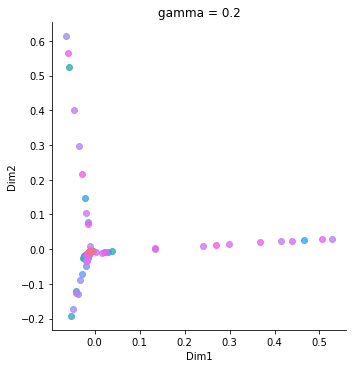

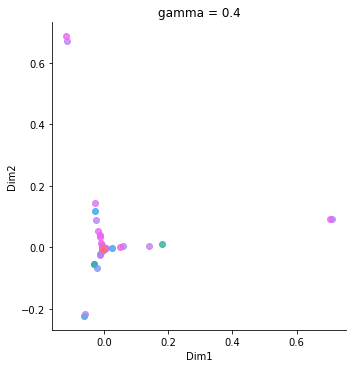

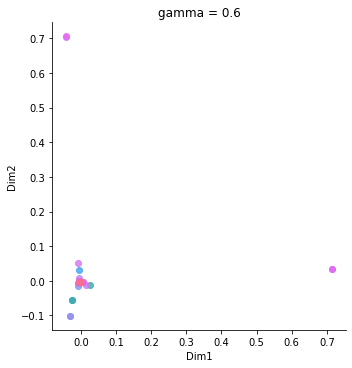

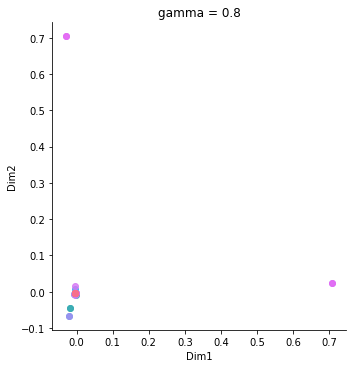

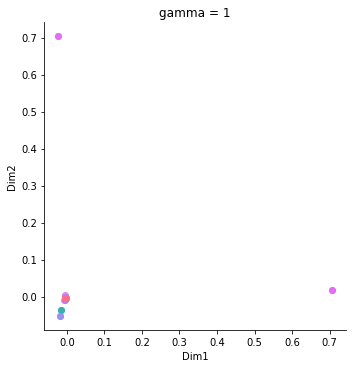

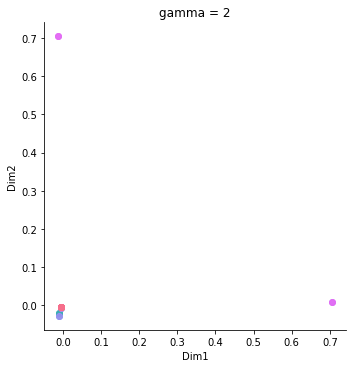

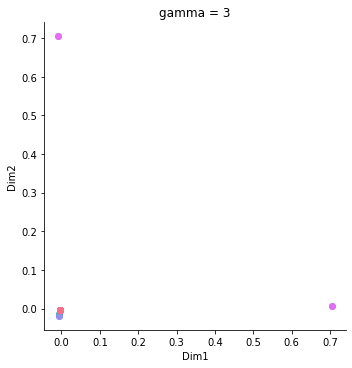

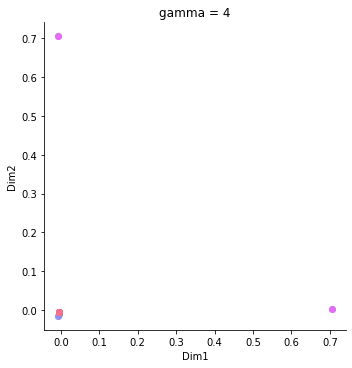

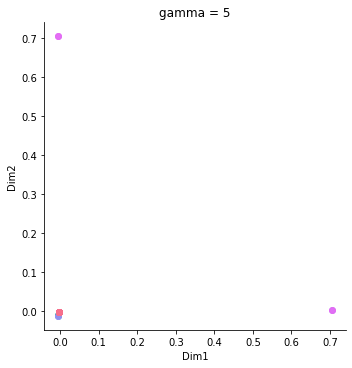

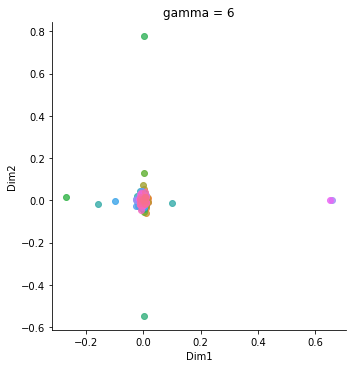

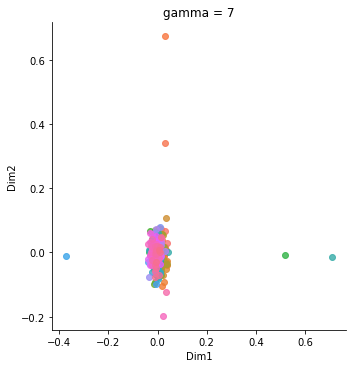

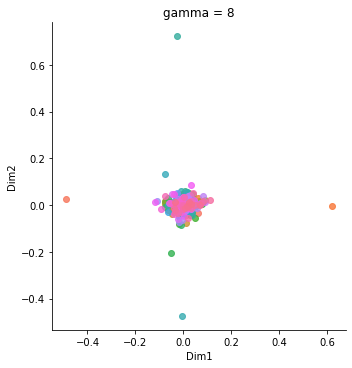

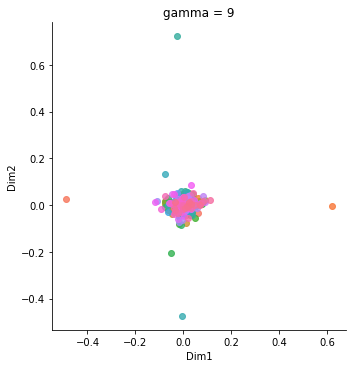

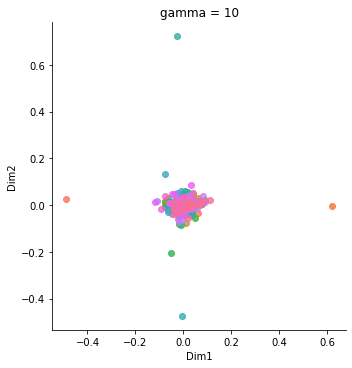

' \npoly indépendant de gamma\nsigmoid ne marche pas\n'

In [ ]:
liste_gamma = [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for gamma in liste_gamma:
  Test_KPCA(gamma,'rbf')

""" 
poly indépendant de gamma
sigmoid ne marche pas
"""